# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

<font color=darkred>
The Bank Marketing dataset, sourced from the UCI Machine Learning Repository, originates from a Portuguese bank's direct marketing campaigns. These campaigns aimed to promote term deposit subscriptions through telemarketing calls. The dataset includes 45,211 instances (after removing duplicates) and 17 attributes capturing customer demographics, campaign details, and economic indicators. The data was collected from a series of telemarketing campaigns conducted by the bank. The response variable ("y") is binary, indicating whether a client subscribed to a term deposit (yes/no).

The goal is to predict whether a client will subscribe to a term deposit ("yes") or not ("no"). This prediction can help the bank optimize its marketing strategies and allocate resources more effectively.
</font>

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import time

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, StandardScaler, OrdinalEncoder,  LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE                # For oversampling minority class 
from imblearn.under_sampling import RandomUnderSampler  # For undersampling majority class
from imblearn.metrics import specificity_score

from sklearn.metrics import RocCurveDisplay, roc_curve, auc

from plot_helpers import render_plot

warnings.simplefilter(action='ignore', category=FutureWarning)

In [79]:
# read the bank data
bankdata = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [80]:
bankdata.sample(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
38655,54,technician,married,basic.9y,no,no,no,cellular,nov,tue,...,2,999,1,failure,-3.4,92.649,-30.1,0.720,5017.5,yes
14068,37,admin.,single,university.degree,no,no,no,cellular,jul,fri,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no
5461,56,services,married,high.school,unknown,no,yes,telephone,may,fri,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [81]:
bankdata.shape

(41188, 21)

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [82]:
bankdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [83]:
bankdata.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [84]:
# Check for duplicates
duplicate_rows = bankdata.duplicated().sum()
print(f'Number of duplicate rows: {duplicate_rows}')

# Remove duplicate rows
bankdata = bankdata.drop_duplicates()
print(f'Dataset shape after removing duplicates: {bankdata.shape}')

# Check for null values
null_values = bankdata.isnull().sum()
print(f'Null values in each column:\n{null_values}')

# Since duration is already deamed to be a predictor of success, and can't predict how long a customer service agent may talk to the client
# how many calls would require to get the answer about deposit, we will drop these feature from the analysis.
bankdata.drop(['campaign','duration', 'pdays'], axis=1, inplace=True)

Number of duplicate rows: 12
Dataset shape after removing duplicates: (41176, 21)
Null values in each column:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [85]:
# Find outliers in the data using the IQR method
numerical_columns = bankdata.select_dtypes(include=['int64', 'float64']).columns

df_numerical = bankdata[numerical_columns]

Q1 = df_numerical.quantile(0.25)
Q3 = df_numerical.quantile(0.75)
IQR = Q3 - Q1

total_outliers = ((df_numerical < (Q1 - 1.5 * IQR)) | (df_numerical > (Q3 + 1.5 * IQR))).sum()
print(f'Outliers in each column:\n{total_outliers}')

outliers = ((df_numerical < (Q1 - 1.5 * IQR)) | (df_numerical > (Q3 + 1.5 * IQR)))


# Remove outliers from the dataset
print(f'Original dataset shape: {bankdata.shape}')
print(f'Removing outliers will change the dataset shape to : {bankdata[~outliers.any(axis=1)].shape}')


Outliers in each column:
age                468
previous          5625
emp.var.rate         0
cons.price.idx       0
cons.conf.idx      446
euribor3m            0
nr.employed          0
dtype: int64
Original dataset shape: (41176, 18)
Removing outliers will change the dataset shape to : (35048, 18)


<font color=darkred>
Even though there are outliers in a few columns such as duration, campaign, pdays, previous. This has been ignored as standard scalar method will be used later.


In [86]:
# review the values in the categorical columns 

for column in bankdata.select_dtypes(include='object').columns:
    print(f"Unique values in {column}: {bankdata[column].unique()}")

Unique values in job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
Unique values in marital: ['married' 'single' 'divorced' 'unknown']
Unique values in education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
Unique values in default: ['no' 'unknown' 'yes']
Unique values in housing: ['no' 'yes' 'unknown']
Unique values in loan: ['no' 'yes' 'unknown']
Unique values in contact: ['telephone' 'cellular']
Unique values in month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
Unique values in day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']
Unique values in poutcome: ['nonexistent' 'failure' 'success']
Unique values in y: ['no' 'yes']


<font color=darkred>The education column, being categorical, may need transformation for analysis or modeling. If it has a meaningful order, ordinal encoding can be used (e.g., assigning increasing values from 'illiterate' to 'university.degree'), while one-hot encoding is preferable if order doesn’t matter. The 'unknown' category should be handled by either dropping rare cases or replacing them with the mode. Additionally, grouping all "basic" education levels into a single category (e.g., "basic.education") can simplify analysis. The choice of encoding depends on the model and business needs. All other categorical columns look good and doesnt need any transformation</font>

## EDA

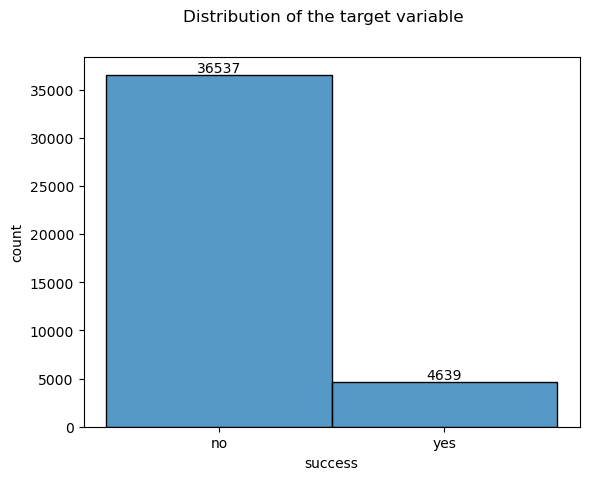

In [87]:
# Examine the distribution of the target variable

ax = sns.histplot(bankdata['y'])

render_plot(ax, 'Distribution of the target variable', xlabel='success', ylabel='count',
            plotname='target_variable_distribution.png', rotation=0)


<font color=darkred>

- bank-additional-full.csv dataset contains both categorical and numerical features.
- No explicit missing values (NaN). Categorical values labeled as "unknown" are present and requires proper handling
- The target variable (y) is imbalanced, meaning more customers did not subscribe to the term deposit than those who did.
- Data set is imbalanced. Majority of the clients (~88%) didnt subscribe (y = "no") to the term deposit. Using SMOTE technique can help here.</font>

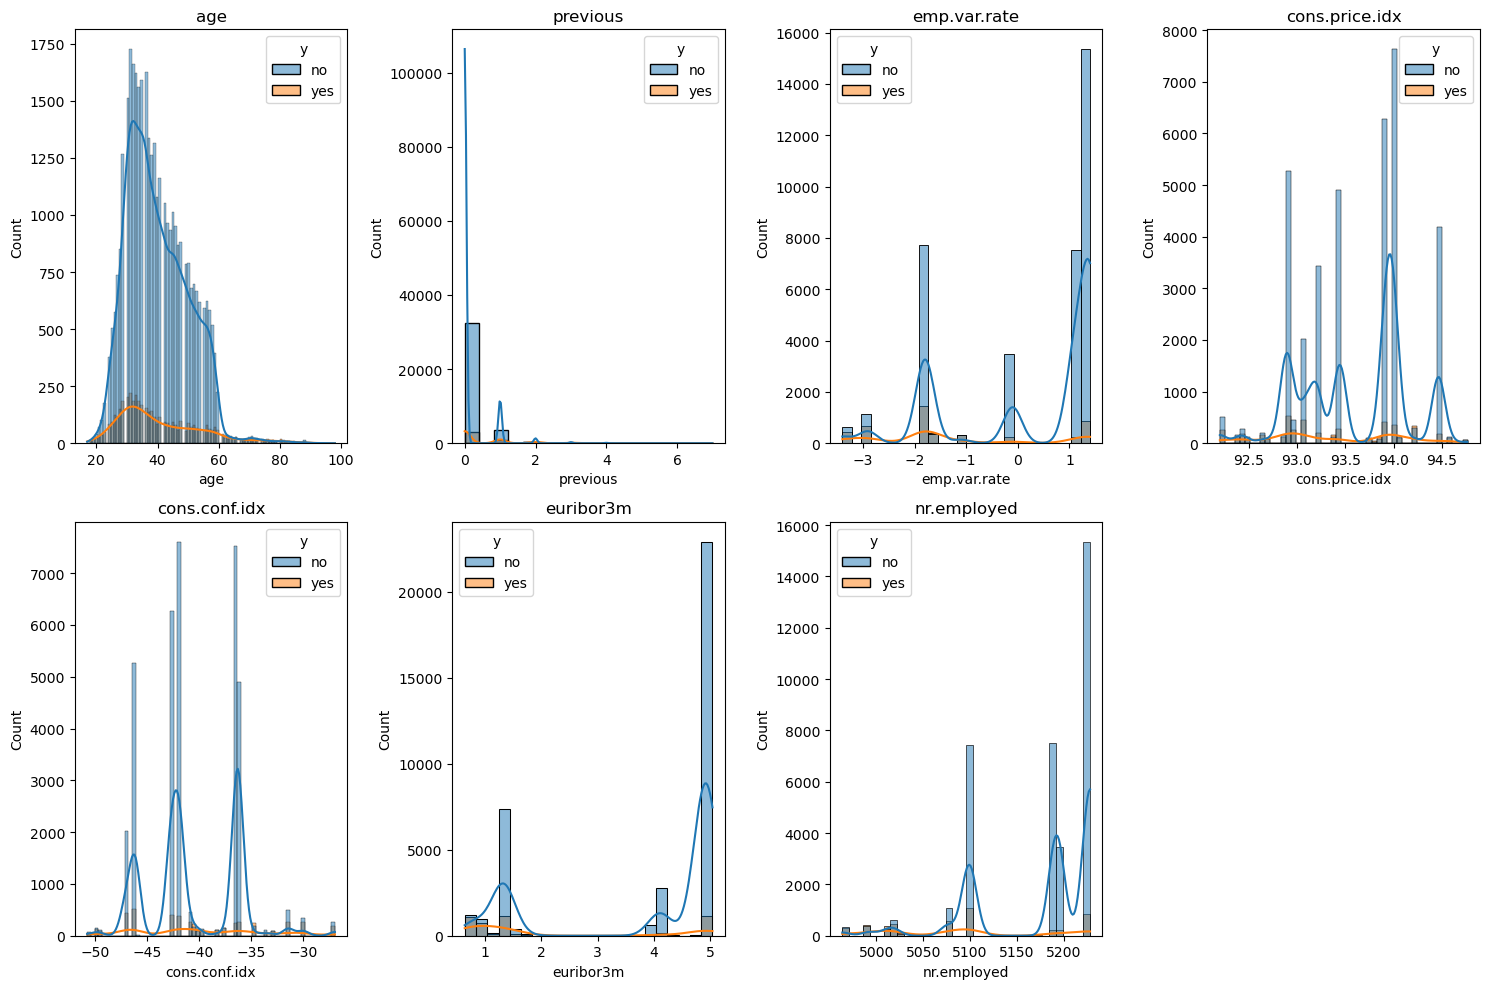

In [88]:
# Plot the distribution of numerical columns

num_cols = 4        # Define the number of rows and columns for the grid
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    ax = sns.histplot(x=bankdata[column], ax=axes[i], hue=bankdata['y'], kde=True)
    ax.set_title(f'{column}')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<font color=darkred>**Distributions of Numerical Columns**

<font color=darkred>
- Age: The distribution of ages is skewed to the right. A larger proportion of younger people (20-40) are not subscribed while the likelihood increases at age 40 and decreases after.

- Previous: Most clients have not been contacted in a previous campaign (0). Subscriptions appear to be slightly higher among those with "previous" campaign contact, but the vast majority are clustered at 0.

- emp.var.rate (Employment Variation Rate): The variable has modes at roughly -3, -2, 0, and +1. Subscriptions appear higher when the employment variation rate is at -3 and decreases when it is at +1.

- cons.price.idx (Consumer Price Index): This variable shows several clusters. Subscriptions seem very marginally higher when cons.price.idx is lower.

- cons.conf.idx (Consumer Confidence Index): This variable is clustered, with the highest counts at more negative values. Subscriptions appear slightly more prevalent when the consumer confidence index is less negative.

- euribor3m (Euribor 3 Month Rate): The distribution is concentrated at higher rates (around 4-5). Subscriptions are noticeably higher when the euribor3m rate is lower (around 1).

- nr.employed (Number of Employees): This has distinct clusters. Subscriptions seem to be somewhat higher when the number of employees is lower (around 5000-5100).
</font>
</font>

In [89]:
#sns.histplot(data = bankdata['euribor3m'], x=)

# Calculate the mean of 'y_numeric' grouped by 'euribor3m'
euribor3m_mean = bankdata.groupby('y')['euribor3m'].mean()
euribor3m_mean


y
no     3.811482
yes    2.123362
Name: euribor3m, dtype: float64

<font color=darkred>Success with customers purchasing bank deposits seems to be higher when the Euribor rates are lower. This is counter intuititve, since a higher Euribor rate would imply higher term deposit rate and hence higher bank deposit acceptance rate. This requires further discussion with a domain expert to understand these rates and its impact.

<Axes: xlabel='y', ylabel='age'>

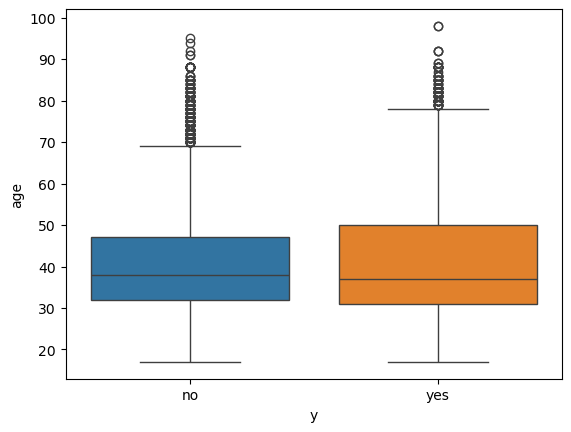

In [90]:
# compare age column with the target variable

sns.boxplot(y=bankdata['age'], x=bankdata['y'], hue=bankdata['y'])


In [91]:
bankdata['y_numeric'] = bankdata['y'].apply(lambda x: 1 if x == 'yes' else 0)

before_60 = round((bankdata[bankdata.age < 60].y_numeric.sum()/sum(bankdata.age < 60))*100, 2)
after_60 = round((bankdata[bankdata.age > 60].y_numeric.sum()/sum(bankdata.age > 60))*100, 2)

print('Before 60: {}% subscribed\nAfter 60: {}% subscribed'.format(before_60, after_60))

Before 60: 10.42% subscribed
After 60: 45.54% subscribed


<font color=darkred>
    
- Median Age: The median age of those who subscribed ("yes") appears to be slightly higher than those who did not subscribe ("no").
- Age Distribution: The age distribution is fairly similar between the two groups, however, there are outliers.
- Outliers: Both groups have a large number of outliers on the higher end of the age range. This indicates that there are many older individuals in the dataset, and their age doesn't necessarily preclude them from either subscribing or not subscribing.
- Range: The box representing those who did subscribe is overall slightly higher than the box for those who did not subscribe.

</font>

Text(0.5, 0, 'Success')

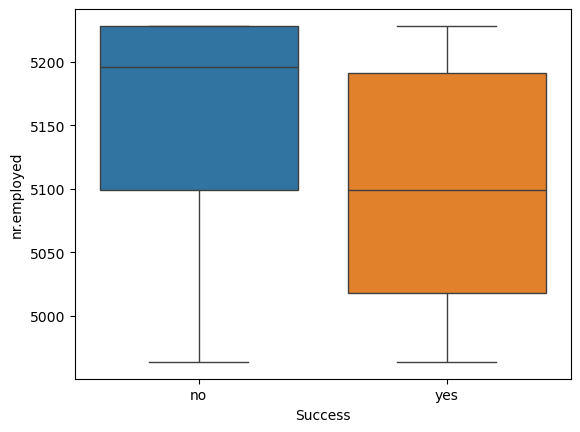

In [92]:
# compare nr.employed in the bank column with the target variable

ax = sns.boxplot(y=bankdata['nr.employed'], x=bankdata['y'], hue=bankdata['y'])
ax.set_xlabel('Success')

<font color=darkred>

- Median nr.employed: The median number of employees is higher for the group that did not subscribe ("no") compared to the group that did subscribe ("yes").
- Distribution: The distribution of "nr.employed" is noticeably different between the two groups.
- Quartiles: The entire boxplot for the "no" group sits higher on the y-axis than the "yes" group. This means that, in general, the number of employees tends to be higher for those who did not subscribe.
- Range: The ranges also differ somewhat.
A lower number of employees ("nr.employed") seems to be correlated with a higher likelihood of subscription ("yes").

A higher number of employees ("nr.employed") seems to be correlated with a lower likelihood of subscription ("no").
</font>


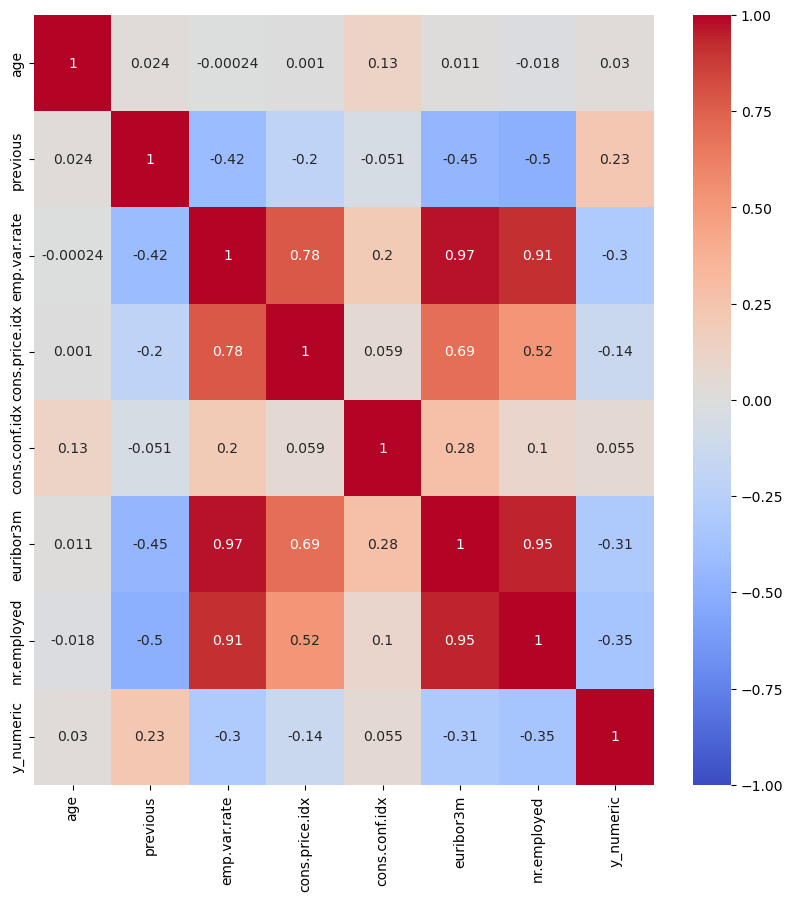

In [93]:
# Review the correlation between numerical columns

plt.figure(figsize=(10, 10))
ax = sns.heatmap(bankdata.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

<font color=darkred>
 
-  Positive Correlation
- emp.var.rate and euribor3m: A very strong positive correlation (0.97). This makes sense, as both are indicators of the economic climate. When employment variation rates are high, interest rates tend to be high as well.
- emp.var.rate and nr.employed: Also a strong positive correlation (0.91). As employment rates increase, so does the number of people employed.
- euribor3m and nr.employed: Strong positive correlation (0.95). This is also logical, as both are related to the overall economic situation.
- emp.var.rate and cons.price.idx: Positive correlation (0.78). This suggests that as employment variation rates increase, so do consumer prices.
- euribor3m and cons.price.idx: Positive correlation (0.69). Similarly, as interest rates increase, so do consumer prices.

- Negative Correlations

- emp.var.rate and previous: Moderate negative correlation (-0.42). This might indicate that the more contacts in previous marketing campaigns, the lower the employment variation rate. This is counterintuitive and may be more related to the timing of the campaigns and general economic trends.
- euribor3m and previous: Moderate negative correlation (-0.45). Similar to the emp.var.rate, this suggests that as interest rates increase, the effectiveness of previous campaigns decreases.
nr.employed and previous: Moderate negative correlation (-0.50). The more people employed the less effective prior campaigns were.
- emp.var.rate and y_numeric: Weak negative correlation (-0.3). Higher employment rate correlates with less likelihood of subscribing.
- euribor3m and y_numeric: Weak negative correlation (-0.31). High interest rate correlated with less likelihood of subscribing.
- nr.employed and y_numeric: Weak negative correlation (-0.35). Higher employment correlated with less likelihood of subscribing.

- Weak Correlation
- age has very weak correlations with all variables.
- cons.conf.idx has weak correlations with all variables.
- cons.price.idx has weak correlations with all variables.

In [94]:

# # Define the categorical columns
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

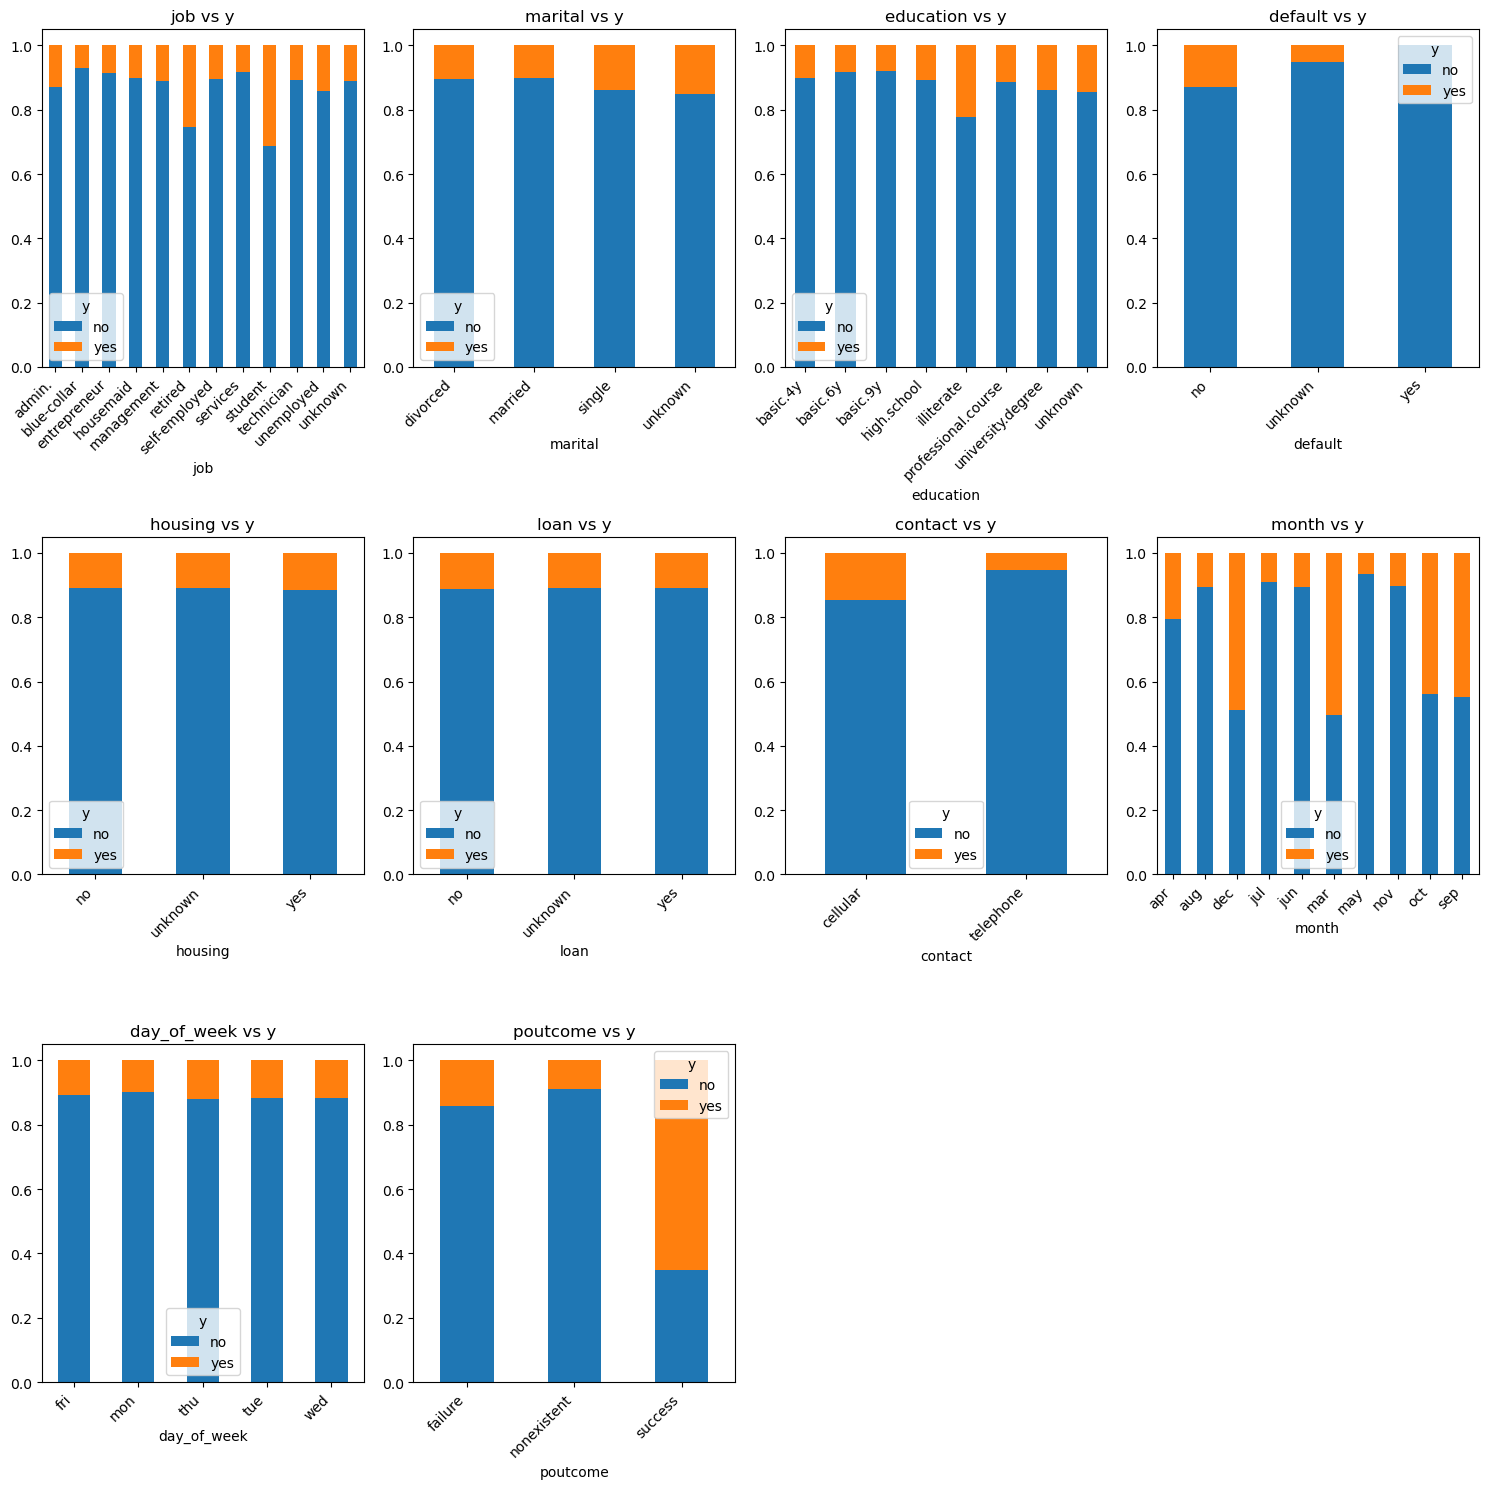

In [95]:
# Examine the categorical variables with y values normalized

# Define the number of rows and columns for the grid
num_cols = 4
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array for easy iterationa
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    # Calculate the ratio
    ratio = bankdata.groupby([column, 'y']).size().unstack().apply(lambda x: x / x.sum(), axis=1)
    ratio.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'{column} vs y')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<font color=darkred>

- job vs “y” subscription:
- Students & Retired: These groups show a significantly higher proportion of "yes" subscriptions compared to other job categories.
- Blue-collar: This group has one of the lowest subscription rates.
- Actionable Insight: Tailor marketing messages specifically to students and retirees, highlighting the benefits relevant to their stage of life. Avoid a one-size-fits-all approach.
- marital vs “y” subscription:
- Single: Shows a higher proportion of "yes" subscriptions compared to married or divorced individuals.
- Married & Divorced: Have relatively similar subscription rates.
- Actionable Insight: Similar to the job category, tailor messaging. Single individuals might be more receptive to certain aspects of a term deposit (e.g., saving for a future goal), while married couples might have different priorities.
- education vs “y” subscription
- Illiterate: This tiny group appears to have a high conversion rate (though the sample size is likely very small, so it's not reliable).
- Basic.4y, Basic.6y, Basic.9y: These education levels have relatively lower "yes" subscription rates.
- University.degree: Shows a higher proportion of "yes" subscriptions compared to those with basic education.
- Actionable Insight: Explore whether more detailed education-specific messaging would be beneficial. Those with university degrees may respond to different arguments than those with only basic education
- default vs “y” subscription:
- No (No credit in default): The vast majority fall into this category, and the "yes" subscription rate is relatively low.
- Yes (Has credit in default): This very small group appears to have slightly higher subscription rates, however this is likely due to the small sample size.
- Actionable Insight: Clients with no credit in default have a much lower subscription rate.
- housing vs “y” subscription
- Yes (Has housing loan): A higher proportion of "no" subscriptions.
- No (Does not have housing loan): The "yes" subscription is slightly higher.
- Actionable Insight: Clients that do not have a housing loan have a higher subscription rate.
- loan vs “y” subscription:
- Yes (Has personal loan): Smaller subscription rate.
- No (Does not have personal loan): Slightly larger subscription rate.
- Actionable Insight: Clients that do not have a personal loan have a higher subscription rate.
- contact vs “y” subscription:
- Cellular: Significantly higher proportion of "yes" subscriptions compared to telephone.
- Telephone: Significantly lower proportion of "yes" subscriptions compared to cellular.
- Actionable Insight: Focus efforts on cellular communication channels, as they are clearly more effective.
- month vs “y” subscription:
- Mar, Sep, Oct, Dec: These months show the highest proportion of "yes" subscriptions.
- Aug, Jul, Jun, May: These months show a low subscription rate.
- Actionable Insight: Concentrate marketing efforts in March, September, October, and December. Consider adjusting strategies for the less effective months. This information corresponds with the EDA from the beginning of the conversation
- day_of_week vs “y” subscription:
- The distribution is very similar across all days of the week.
- Actionable Insight: Day of the week likely does not play a significant role in subscription rates. This variable is not significant to the model.
- poutcome vs “y” subscription:
- Success: Those who had a "successful" outcome in the previous campaign have a very high subscription rate this time around.
- Failure: Much lower conversion rate.
- Nonexistent: Most people fall in this category and the subscription rate is relatively low.
- Actionable Insight: Prior campaign success is a strong predictor of future success. Focus efforts on those who were previously successful.


Returning customers who has subscribed to the new term deposit: 65%


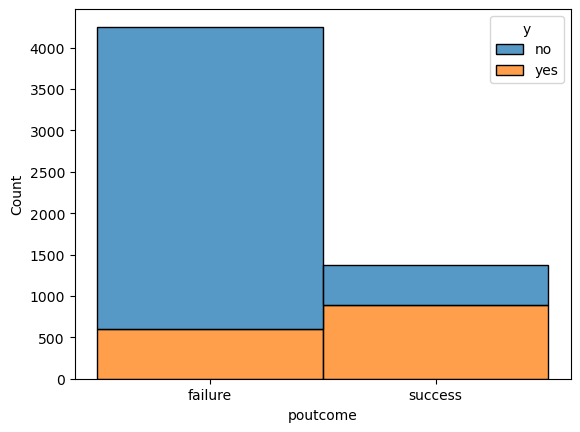

In [96]:
# Examine the success of campaigns with those customers who the bank had success before

bank_prevoutcome = bankdata[(bankdata['poutcome'] == 'success') | (bankdata['poutcome'] == 'failure')][['poutcome', 'y']]
bank_prevoutcome.head(3)

sns.histplot(data=bank_prevoutcome, x='poutcome', hue='y', multiple='stack')

returned_customers = len(bankdata[(bankdata.poutcome=='success') & (bankdata.y=='yes')])/len(bankdata[bankdata.poutcome=='success'])
print('Returning customers who has subscribed to the new term deposit: {}%'.format(round(returned_customers*100)))

<font color=darkred>Repeat/Returning customers subscribed more to the term deposit </font>

<Axes: xlabel='month', ylabel='count'>

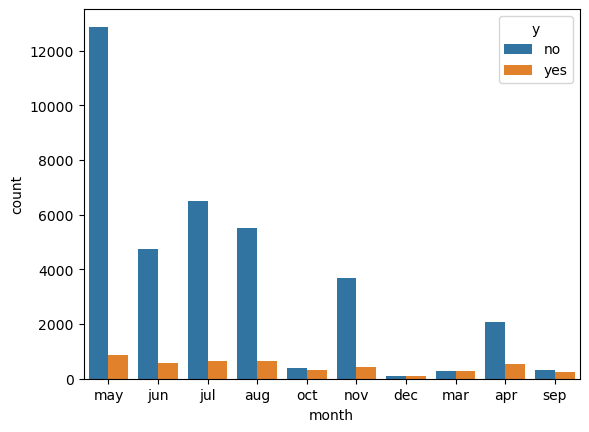

In [97]:
# compare the number of calls made across months, to see if the highest number of calls are made in months with high chance of success

sns.countplot(x='month', hue='y', data=bankdata)

<font color=darkred> 
- May, June, July, August: Low conversion rates These months exhibit the highest number of contacts ("no" subscriptions) and some of the lowest rates of "yes" subscriptions. 
- March, September, October, December: High Conversion Rates. Note: These months have much fewer contacts overall than the summer months.
</font>

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### Business Objective
<font color=darkred>
Build a machine learning model with the objective to predict whether a client will subscribe to a term deposit ("yes") or not ("no") based on customer persona, features that help provide insights on customer behavior to subscribe to a term deposit. This prediction can help the bank optimize its marketing strategies and allocate resources more effectively. 

### Problem 5: Feature Engineering

To build an effective model, we first need to perform feature engineering on the bank-related data. This involves encoding categorical variables, handling missing or unknown values, and transforming features to enhance model performance. We will prepare the feature set and target column by applying appropriate encoding techniques, grouping similar categories where necessary, and ensuring the data is structured optimally for modeling.

<font color=darkred>

- education feature needs to be transformed as identified earlier. 

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [98]:
X = bankdata.drop(columns = ['y', 'y_numeric'])  
y = bankdata['y']

# categorical columns
X_encoded = pd.get_dummies(X)

scaler = StandardScaler()

# Scale only numerical columns
numerical_cols = X_encoded.select_dtypes(include=['int64', 'float64']).columns
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=0)

print(X_train.shape, X_test.shape)
y_train.value_counts()

(28823, 60) (12353, 60)


y
no     25618
yes     3205
Name: count, dtype: int64

In [99]:
# Undersample for the minority class
undersampler = RandomUnderSampler(random_state=0)

# Apply the undersampler to the training data
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

# Check the new class distribution
print(f'Class distribution after undersampling:\n{y_train_undersampled.value_counts()}')

Class distribution after undersampling:
y
no     3205
yes    3205
Name: count, dtype: int64


In [100]:
# Oversample the minority class using SMOTE
smote = SMOTE(random_state=0)  

X_train_oversample, y_train_oversample = smote.fit_resample(X_train, y_train) 

# after oversampling the minority class
print(f'After balancing the target variable is: {y_train_oversample.value_counts()}')

After balancing the target variable is: y
no     25618
yes    25618
Name: count, dtype: int64


### Helper functions

In [101]:
# HELPER FUNCTIONS

#empty dataframe to store the results of all gridsearch modelevaluations
models_evaluated = pd.DataFrame()

# Fit the grid
def fit_grid(grid, X_train, y_train):
    start = time.time()
    grid.fit(X_train, y_train)
    end = time.time()
    fitTime = end - start
    return round(fitTime,2)

# Predict using the grid
def predict_grid(grid, X_test):
    start = time.time()
    y_pred = grid.predict(X_test)
    end = time.time()
    predictTime = end - start
    return y_pred, round(predictTime,2)

# Extract scores from the models, and print confusion matrix

def get_scores_and_displaycm(fitted_grid, model_prefix, y_test, y_pred, fitTime, predictTime):

    _classes = fitted_grid.best_estimator_.named_steps[model_prefix].classes_
    cm = confusion_matrix(y_test, y_pred, labels = _classes)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = _classes)
    # show the plot    
    plt.figure(figsize=(3, 3))
    disp.plot()
    plt.show()
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, pos_label='yes')
    precision = precision_score(y_test, y_pred, pos_label='yes')
    specificity = specificity_score(y_test, y_pred, pos_label='yes')
    f1 = f1_score(y_test, y_pred, pos_label='yes')
    
    print(classification_report(y_test, y_pred))

    pred = fitted_grid.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label='yes')
    grid_auc = auc(fpr, tpr)
    
    # find the grid fit time for the best model
    grid_fit_time_rank1_model = pd.DataFrame(fitted_grid.cv_results_).query('rank_test_score == 1').mean_fit_time.values[0]
    
    return {'model': model_prefix, 
            'test accuracy': round(accuracy,3),
            'precision': round(precision,3), 
            'recall': round(recall,3),
            'specificity': round(specificity,3),
            'f1': round(f1,3),
            'AUC': round(grid_auc,3),
            'grid total fit time': round(fitTime,3),
            'best model mean fit time': round(grid_fit_time_rank1_model,3),
            'grid predict time': round(predictTime,3),
            'best params': fitted_grid.best_params_
}

def fit_predict_evaluate(grid, model_name, X_train, y_train, X_test, y_test):    
    
    #fit the grid
    fitTime = fit_grid(grid, X_train, y_train)

    # make predictions
    y_pred, predictTime = predict_grid(grid, X_test)

    # show confusion matrix and other scores
    dict = get_scores_and_displaycm(grid, model_name, y_test, y_pred, fitTime, predictTime)

    # returns the results/scores of this evaluation
    return dict

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [102]:
from sklearn.dummy import DummyClassifier

In [103]:
dc = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
print (dc.score(X_test, y_test))


0.883914838500769


### Problem 8: A Basic Model - Logistic Regression

Use Logistic Regression to build a basic model on your data.  

AUC: 0.7890830708565997


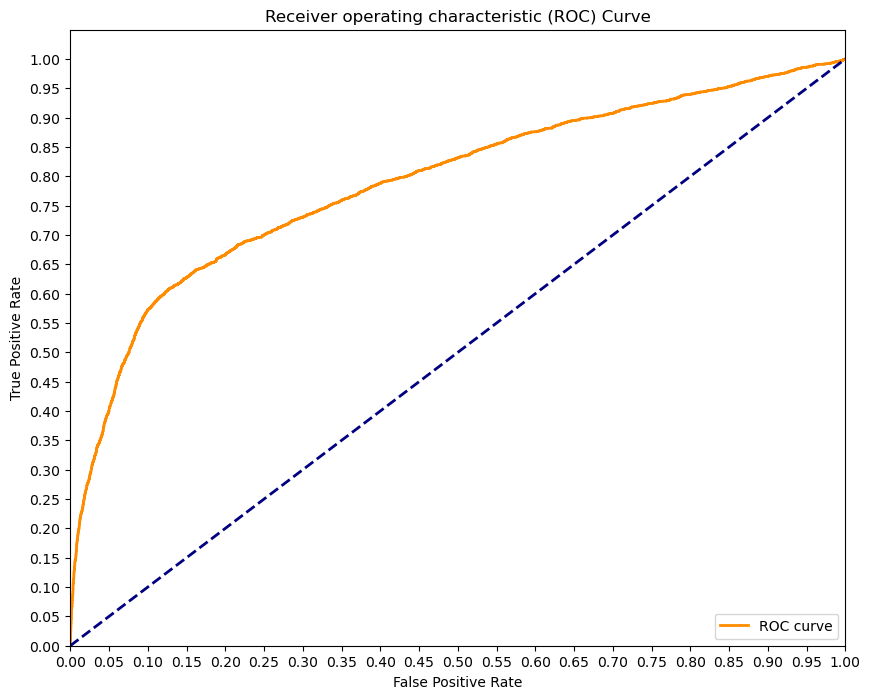

In [104]:
lr = LogisticRegression(fit_intercept=False, random_state=42, n_jobs=-1, max_iter=10000)
lr.fit(X_train, y_train)

y_score = lr.decision_function(X_train)
pred = lr.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_train, y_score, pos_label='yes')

grid_auc = auc(fpr, tpr)

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [105]:
# Evaluate Logistic Regression

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          no       0.91      0.99      0.94     10919
         yes       0.69      0.21      0.32      1434

    accuracy                           0.90     12353
   macro avg       0.80      0.60      0.63     12353
weighted avg       0.88      0.90      0.87     12353



<font color=darkred>Primary goal is to improve F1-score and recall metric. While a high precision is important, a higher recall is more important so we do not turn away customers who could have purchased the term deposits.

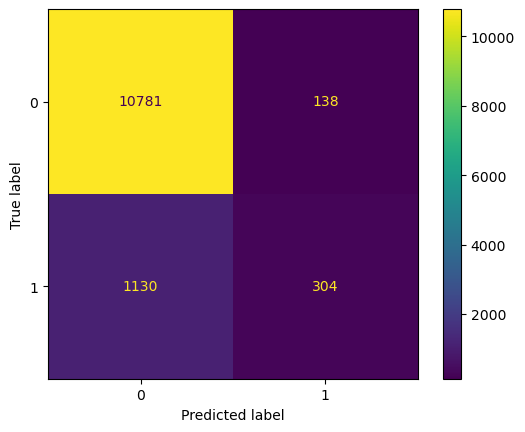

In [106]:
# print confusion matrix

cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(cm).plot()

In [107]:
#   get the feature names
feature_names = lr.feature_names_in_

# clean the feature names
clean_feature_names = [name.split('__')[-1] for name in feature_names]

# get the coefficients
coefficients = lr.coef_[0]

# convert the coefficients to odds ratio
coefficients = np.exp(coefficients)

coefficients_df = pd.DataFrame({'feature': clean_feature_names, 'coefficient': coefficients})

coefficients_df.sort_values('coefficient', ascending=False).head(10)

,feature,coefficient
47,month_mar,3.355442
3,cons.price.idx,2.748474
59,poutcome_success,2.122189
5,euribor3m,1.765418
27,education_illiterate,1.523033
43,month_aug,1.270536
44,month_dec,1.259617
12,job_retired,1.199889
6,nr.employed,1.153019
15,job_student,1.134140


### Problem 9: Evaluate KNN, LR, SVM and DT with default parameters for balanced (under and oversample)

In [108]:
lr = LogisticRegression(fit_intercept=False, random_state=42, n_jobs=-1, max_iter=10000) 
svm = SVC()
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()

classifiers = [lr, svm, dt, knn]
classifiers_names = ['Logistic Regression', 'SVM','Decision Tree', 'KNN']

#### Testing classifiers with default parameters and with balanced dataset (over sampled)

In [109]:
scores = []
for i in range(len(classifiers)):
    
    #fit the grid
    fitTime = fit_grid(classifiers[i], X_train_oversample, y_train_oversample)

    # make predictions
    y_pred, predictTime = predict_grid(classifiers[i], X_test)

    recall = recall_score(y_test, y_pred, pos_label='yes')
    precision = precision_score(y_test, y_pred, pos_label='yes')
    f1 = f1_score(y_test, y_pred, pos_label='yes')
    accuracy = accuracy_score(y_test, y_pred)

    classifier_metrics = {'Classifier': classifiers_names[i], 'accuracy': accuracy,
                          'F1-Score': f1, 'Precision': precision, 'Recall': recall, 
                          'Fit Time': fitTime}
    
    scores.append(classifier_metrics)
    
scores_df = pd.DataFrame(scores)
scores_df

,Classifier,accuracy,F1-Score,Precision,Recall,Fit Time
0,Logistic Regression,0.883348,0.475809,0.497338,0.456067,2.04
1,SVM,0.895329,0.410934,0.592641,0.314505,125.83
2,Decision Tree,0.840363,0.336027,0.324870,0.347978,0.64
3,KNN,0.847405,0.399873,0.367897,0.437936,0.14


#### Testing classifiers with balanced variables and with balanced dataset (under sampled)

In [110]:
scores = []
for i in range(len(classifiers)):

    #fit the grid
    fitTime = fit_grid(classifiers[i], X_train_undersampled, y_train_undersampled)

    # make predictions
    y_pred, predictTime = predict_grid(classifiers[i], X_test)

    recall = recall_score(y_test, y_pred, pos_label='yes')
    precision = precision_score(y_test, y_pred, pos_label='yes')
    f1 = f1_score(y_test, y_pred, pos_label='yes')
    accuracy = accuracy_score(y_test, y_pred)

    classifier_metrics = {'Classifier': classifiers_names[i], 'accuracy': accuracy,
                          'F1-Score': f1, 'Precision': precision, 'Recall': recall, 
                          'Fit Time': fitTime}
    
    scores.append(classifier_metrics)
    
scores_df = pd.DataFrame(scores)
scores_df

,Classifier,accuracy,F1-Score,Precision,Recall,Fit Time
0,Logistic Regression,0.824982,0.458959,0.357923,0.639470,1.35
1,SVM,0.844815,0.483149,0.393846,0.624826,3.11
2,Decision Tree,0.647292,0.306321,0.198473,0.670851,0.07
3,KNN,0.739820,0.375437,0.260237,0.673640,0.02


<font color=darkred>

**Logistic Regression** and **SVM** best performance and are pretty close on F1-Score. Continuing with GridSearchCV 

### Problem 10: Logistic Regression GridSearchCV

In [111]:
params = {'lr__solver': ['lbfgs', 'liblinear'],
                   'lr__C': [0.0001, 0.0001, 0.001, 1.0]}

max_iterations = 10000

Fitting 5 folds for each of 8 candidates, totalling 40 fits


<Figure size 300x300 with 0 Axes>

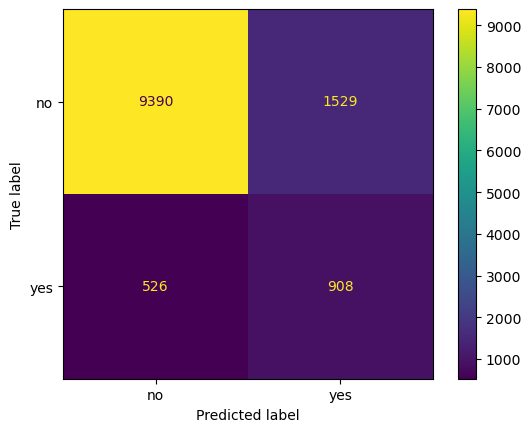

              precision    recall  f1-score   support

          no       0.95      0.86      0.90     10919
         yes       0.37      0.63      0.47      1434

    accuracy                           0.83     12353
   macro avg       0.66      0.75      0.69     12353
weighted avg       0.88      0.83      0.85     12353



,model,test accuracy,precision,recall,specificity,f1,AUC,grid total fit time,best model mean fit time,grid predict time,best params
0,lr,0.834,0.373,0.633,0.86,0.469,0.802,5.64,0.387,0.03,"{'lr__C': 1.0, 'lr__solver': 'liblinear'}"


In [112]:
# Logistic Regression model

lr_pipe = Pipeline([('scaler', StandardScaler()),('lr', LogisticRegression(fit_intercept=False, 
                                                                           random_state=42, 
                                                                           max_iter=max_iterations))])

#lr_grid = GridSearchCV(lr_pipe, params, cv=5, scoring='roc_auc', n_jobs=10, verbose=1)
lr_grid = GridSearchCV(lr_pipe, params, cv=5, n_jobs=10, verbose=1)


# fit and evaluate the model
dict = fit_predict_evaluate(lr_grid, 'lr', X_train_undersampled, y_train_undersampled, X_test, y_test)

models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)
models_evaluated


In [113]:
# get the feature names
feature_names = lr_grid.best_estimator_.feature_names_in_

# clean the feature names
clean_feature_names = [name.split('__')[-1] for name in feature_names]
clean_feature_names[:5]


['age', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx']

<font color=darkred>
Logistic regression outputs log-odds, which can be converted to odds ratios by exponentiating the coefficients. We will transform the log-odds into odds ratios and identify the top 10 features with the highest impact on the model.

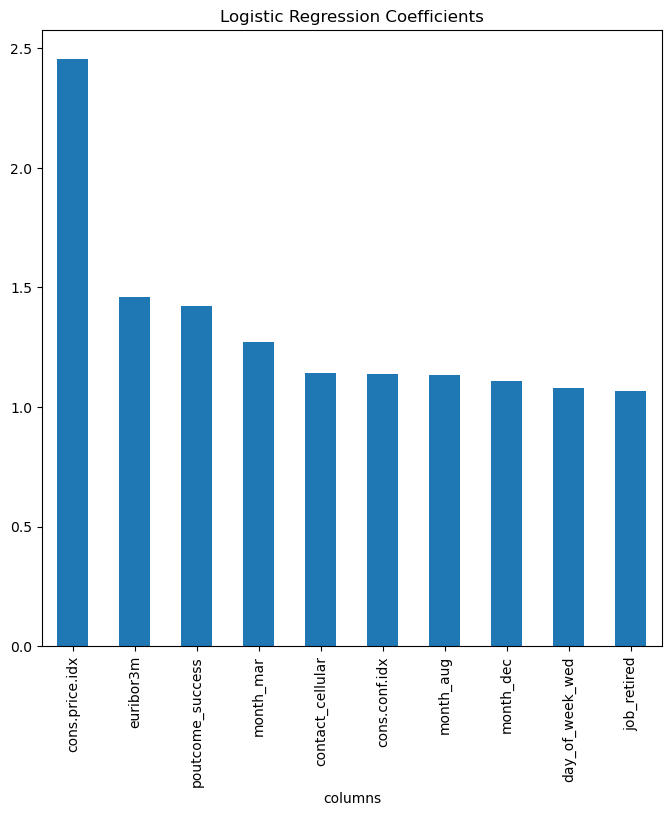

In [114]:
# get the coefficients
coefficients = lr_grid.best_estimator_.named_steps["lr"].coef_[0]

# convert the coefficients to odds ratio
coefficients = np.exp(coefficients)

# converting coefficients into df 
lr_results = pd.DataFrame({"columns": clean_feature_names, "values" : coefficients}).sort_values(by = "values", ascending = False)

# bar plot
lr_results.head(10).plot(kind='bar', x='columns', y='values', legend=False, figsize=(8, 8))

# Adding labels and title to the plot
plt.title('Logistic Regression Coefficients')

# Display the plot
plt.show()

<font color=darkred>

The odds of success are influenced by factors such as the consumer price index, Euribor rates, and the success of previous outcomes.

In [115]:
lr_results.tail(10).sort_values(by= 'values', ascending = True)   

,columns,values
2,emp.var.rate,0.161439
33,default_yes,0.207189
57,poutcome_failure,0.814331
48,month_may,0.833496
41,contact_telephone,0.875451
58,poutcome_nonexistent,0.903655
46,month_jun,0.917715
49,month_nov,0.926448
53,day_of_week_mon,0.935872
23,education_basic.4y,0.958567


### 8 Decision Tree Model

In [116]:
# setup a GridSearchCV for the Decision Tree model

params = {'dt__min_impurity_decrease': [0.001, 0.01, 0.1],
         'dt__max_depth': [6,8,10],
         'dt__min_samples_split': [0.1, 0.05]}

#params = {'dt__max_depth': [2,4,6,8,10]}

# transformer = make_column_transformer(
#     (OneHotEncoder(drop='if_binary'), [col for col in categorical_columns if col != 'education']),
#     (OrdinalEncoder(categories=[['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree', 'unknown']]), ['education'])
# )

dt_pipe = Pipeline([('dt', DecisionTreeClassifier(random_state = 42))])
#dt_grid = GridSearchCV(estimator=dt_pipe, param_grid=params, scoring='roc_auc', n_jobs=10, verbose=3)

dt_grid = GridSearchCV(estimator=dt_pipe, param_grid=params, n_jobs=10, verbose=2)

dt_grid

GridSearchCV(estimator=Pipeline(steps=[('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=10,
             param_grid={'dt__max_depth': [6, 8, 10],
                         'dt__min_impurity_decrease': [0.001, 0.01, 0.1],
                         'dt__min_samples_split': [0.1, 0.05]},
             verbose=2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.1; total time=   0.1s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.1; total time=   0.1s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.1; total time=   0.1s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.1; total time=   0.1s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.1; total time=   0.1s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.05; total time=   0.1s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.05; total time=   0.1s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.05; total time=   0.1s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.05; total tim

<Figure size 300x300 with 0 Axes>

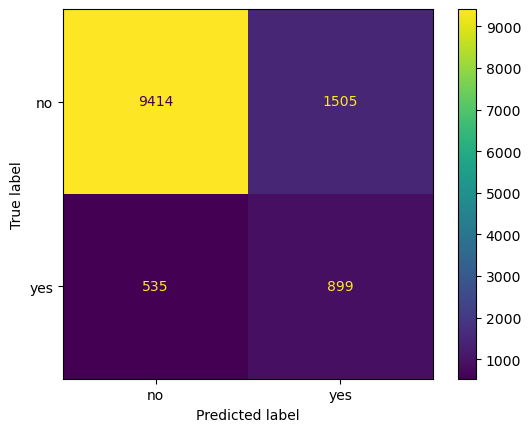

              precision    recall  f1-score   support

          no       0.95      0.86      0.90     10919
         yes       0.37      0.63      0.47      1434

    accuracy                           0.83     12353
   macro avg       0.66      0.74      0.69     12353
weighted avg       0.88      0.83      0.85     12353



,model,test accuracy,precision,recall,specificity,f1,AUC,grid total fit time,best model mean fit time,grid predict time,best params
0,lr,0.834,0.373,0.633,0.860,0.469,0.802,5.64,0.387,0.03,"{'lr__C': 1.0, 'lr__solver': 'liblinear'}"
1,dt,0.835,0.374,0.627,0.862,0.468,0.794,1.19,0.057,0.01,"{'dt__max_depth': 6, 'dt__min_impurity_decreas..."


In [117]:
# fit the model and evaluate the model
dict = fit_predict_evaluate(dt_grid, 'dt', X_train_undersampled, y_train_undersampled, X_test, y_test)

models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)
models_evaluated

In [118]:
# export the tree

feature_names = dt_grid.best_estimator_.feature_names_in_

# clean the feature names
clean_feature_names = [name.split('__')[-1] for name in feature_names]
print(clean_feature_names)

dt = dt_grid.best_estimator_.named_steps['dt']

depth = export_text(dt, feature_names=clean_feature_names)
export_text(dt, feature_names=clean_feature_names, show_weights=True)

print(depth)

['age', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure'

In [119]:
# check for the importance of features

features_importance = pd.DataFrame({'feature': clean_feature_names, 'importance': dt.feature_importances_})
    
features_importance.sort_values(by='importance', ascending=False).head(10)

,feature,importance
6,nr.employed,0.722256
4,cons.conf.idx,0.160122
5,euribor3m,0.062329
50,month_oct,0.024472
59,poutcome_success,0.022567
3,cons.price.idx,0.008254
39,loan_yes,0.000000
43,month_aug,0.000000
42,month_apr,0.000000
41,contact_telephone,0.000000


<font color=darkred>

Decision tree highlights the importance of the number of employees, consumer confidence index, consumer price index, outcome of previous campaigns, and the euribor 3 month rate in predicting term deposit subscriptions. Lower number of employees and euribor 3 month rate seem to generally correlated to a higher likelihood of subscription



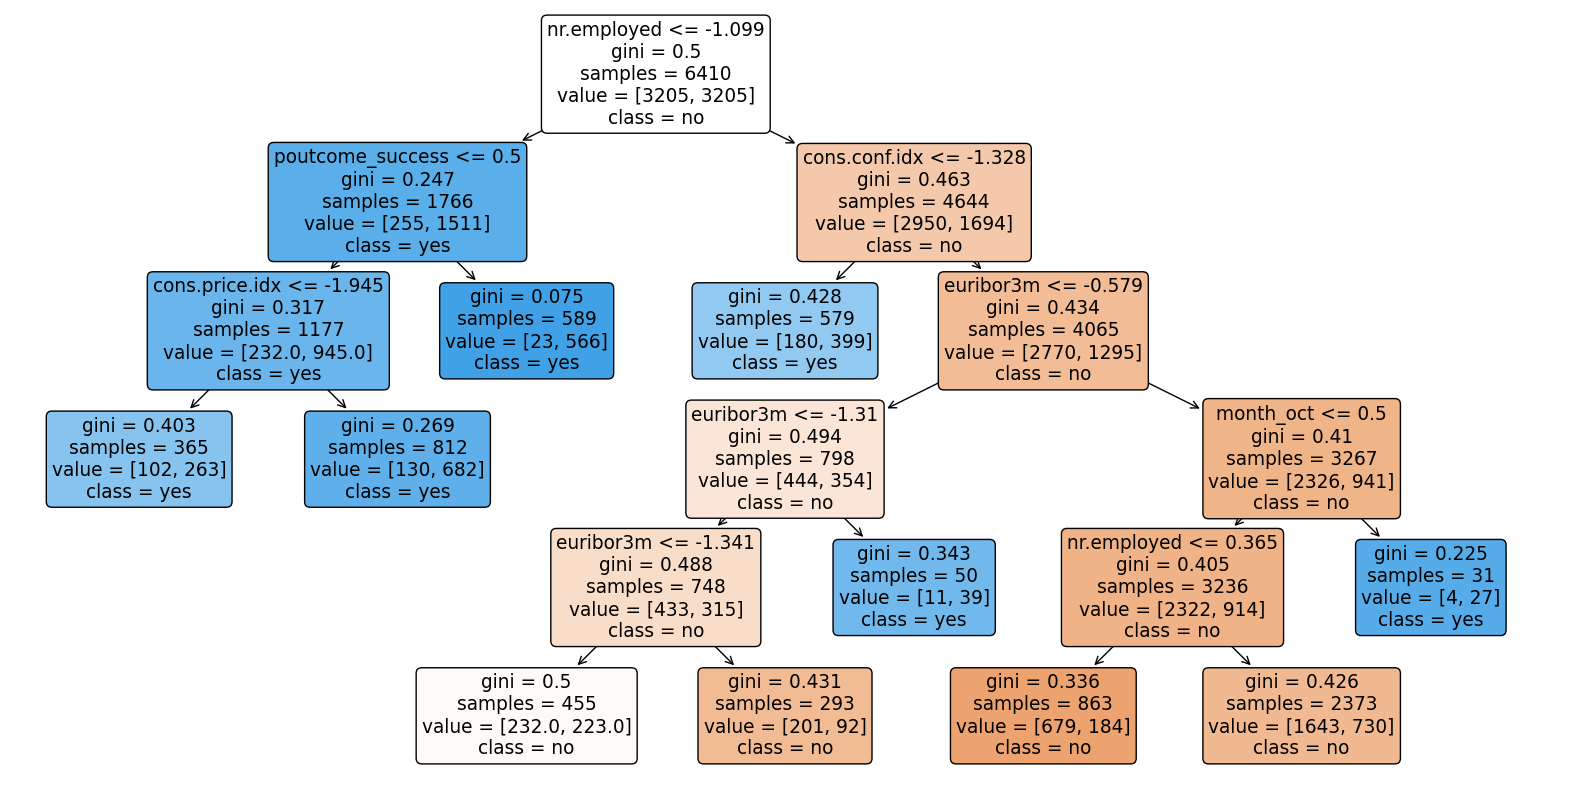

In [120]:
from sklearn.tree import plot_tree

# Get the best decision tree model
dt = dt_grid.best_estimator_.named_steps['dt']

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=clean_feature_names, class_names=dt.classes_, filled=True, rounded=True)
plt.show()

### 8 SVM

In [121]:
# setup a GridSearchCV for the SVM model


# params = {'svm__kernel': ['rbf', 'poly', 'linear'],
#          'svm__gamma': [0.1, 1.0],}

# unable to run multiple parameters as it takes a long time to complete the grid search
#

params = {'svm__kernel': ['linear', 'sigmoid', 'rbf', 'poly'],}

svm_pipe = Pipeline([('scaler', StandardScaler()), ('svm', SVC(random_state = 42, probability=True))])

svm_grid = GridSearchCV(estimator=svm_pipe, param_grid=params, scoring='roc_auc', n_jobs=10, verbose=4)

svm_grid

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=10,
             param_grid={'svm__kernel': ['linear', 'sigmoid', 'rbf', 'poly']},
             scoring='roc_auc', verbose=4)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 5/5] END ...............svm__kernel=sigmoid;, score=0.704 total time=  20.4s
[CV 1/5] END ...............svm__kernel=sigmoid;, score=0.715 total time=  20.6s
[CV 4/5] END ...............svm__kernel=sigmoid;, score=0.728 total time=  20.6s
[CV 3/5] END ...............svm__kernel=sigmoid;, score=0.716 total time=  20.7s
[CV 2/5] END ...............svm__kernel=sigmoid;, score=0.736 total time=  21.2s
[CV 1/5] END ...................svm__kernel=rbf;, score=0.768 total time=  29.2s
[CV 4/5] END ...................svm__kernel=rbf;, score=0.772 total time=  29.2s
[CV 5/5] END ...................svm__kernel=rbf;, score=0.751 total time=  28.9s
[CV 2/5] END ...................svm__kernel=rbf;, score=0.768 total time=  29.5s
[CV 3/5] END ...................svm__kernel=rbf;, score=0.778 total time=  29.6s
[CV 1/5] END ..................svm__kernel=poly;, score=0.765 total time=  24.2s
[CV 2/5] END ..................svm__kernel=poly;,

<Figure size 300x300 with 0 Axes>

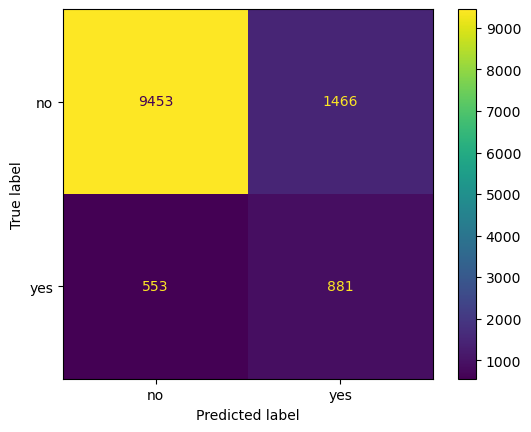

              precision    recall  f1-score   support

          no       0.94      0.87      0.90     10919
         yes       0.38      0.61      0.47      1434

    accuracy                           0.84     12353
   macro avg       0.66      0.74      0.68     12353
weighted avg       0.88      0.84      0.85     12353



,model,test accuracy,precision,recall,specificity,f1,AUC,grid total fit time,best model mean fit time,grid predict time,best params
0,lr,0.834,0.373,0.633,0.860,0.469,0.802,5.64,0.387,0.03,"{'lr__C': 1.0, 'lr__solver': 'liblinear'}"
1,dt,0.835,0.374,0.627,0.862,0.468,0.794,1.19,0.057,0.01,"{'dt__max_depth': 6, 'dt__min_impurity_decreas..."
2,svm,0.837,0.375,0.614,0.866,0.466,0.776,393.05,178.537,2.30,{'svm__kernel': 'linear'}


In [122]:
# fit the model and evaluate the model

# fit the model and evaluate the model
dict = fit_predict_evaluate(svm_grid, 'svm', X_train_undersampled, y_train_undersampled, X_test, y_test)

models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)
models_evaluated

In [123]:
# get the feature names
#feature_names = lr_grid.best_estimator_.named_steps['scaler'].get_feature_names_out()
feature_names = svm_grid.best_estimator_.feature_names_in_

# clean the feature names
clean_feature_names = [name.split('__')[-1] for name in feature_names]
clean_feature_names[:5]

features_importance = svm_grid.best_estimator_.named_steps['svm'].coef_

pd.DataFrame({'feature': clean_feature_names, 'importance': features_importance[0]}).sort_values(by='importance', ascending=False).head(10)

,feature,importance
5,euribor3m,1.704951
3,cons.price.idx,0.810437
42,month_apr,0.290238
43,month_aug,0.261658
47,month_mar,0.222180
59,poutcome_success,0.097907
45,month_jul,0.082010
4,cons.conf.idx,0.069735
22,marital_unknown,0.001738
40,contact_cellular,0.001633


### Problem 9: Score the Model

What is the accuracy of your model?

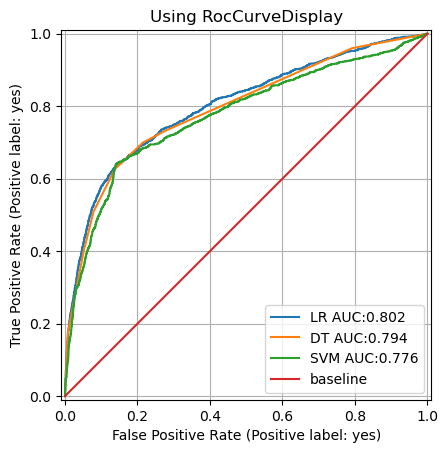

In [124]:
# create ROC curve for all the models

fig, ax = plt.subplots()

lr_label = 'LR AUC:' + str(models_evaluated[models_evaluated['model'] == 'lr']['AUC'].values[0])
#knn_label = 'KNN AUC:' + str(models_evaluated[models_evaluated['model'] == 'knn']['AUC'].values[0])
dt_label = 'DT AUC:' + str(models_evaluated[models_evaluated['model'] == 'dt']['AUC'].values[0])
svm_label = 'SVM AUC:' + str(models_evaluated[models_evaluated['model'] == 'svm']['AUC'].values[0])

#RocCurveDisplay.from_estimator(knn_grid, X_test, y_test, pos_label = 'yes', ax = ax, label = knn_label)
RocCurveDisplay.from_estimator(lr_grid, X_test, y_test, pos_label = 'yes', ax = ax, label = lr_label)
RocCurveDisplay.from_estimator(dt_grid, X_test, y_test, pos_label = 'yes', ax = ax, label =  dt_label    )
RocCurveDisplay.from_estimator(svm_grid, X_test, y_test, pos_label = 'yes', ax = ax, label = svm_label) 
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('Using RocCurveDisplay')
plt.legend();

### Conclusion

Based on the analysis of ROC curves and AUC scores, Model Performance Assessment is performed based on the analysis of ROC curves and AUC scores. The ROC (Receiver Operating Characteristic) curve visualizes the performance of a binary classifier by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The AUC (Area Under the Curve) score quantifies the overall ability of the model to distinguish between positive and negative instances. A higher AUC indicates better performance.
•	Logistic Regression (LR): AUC = 0.802 - Performs the best among the three models.
•	Decision Tree (DT): AUC = 0.794 - Performs slightly worse than Logistic Regression.
•	Support Vector Machine (SVM): AUC = 0.776 - Performs the worst among the three models.
•	Baseline: The baseline is the diagonal line, representing random chance (AUC = 0.5). All the models perform significantly better than random chance


### Next steps

- Hyperparameter tuning - Further experimentation with hyperparameter tuning for all three models, particularly the Logistic Regression and Decision Tree, to see if you can squeeze out better performance
- Interaction Terms: Based on EDA (especially the correlations and bar charts), create interaction terms between features that seem to have a combined effect on the target variable.
- Polynomial Features: Consider adding polynomial features to capture non-linear relationships.
- Feature Selection/Dimensionality Reduction:
- Regularization: For Logistic Regression, experiment with L1 (Lasso) or L2 (Ridge) regularization to reduce overfitting and potentially improve generalization.
- PCA/Feature Importance: Use PCA or feature importance from a tree-based model (e.g., Random Forest) to select the most relevant features and reduce dimensionality.
- Subscriptions are noticeably higher when the euribor3m rate is lower. Requires further discovery and understanding.
- Recommend incorporating external data sources (e.g., demographic data, economic indicators) to enrich banking feature set
- A/B Testing: Once you have a refined model, perform A/B testing on a small segment of your customer base to compare the performance of ML (LR) model-driven marketing strategy against your current approach.
- Monitoring: Continuously monitor the performance of the model in a production environment and retrain it periodically with new data to maintain its accuracy and relevance.
